In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.patches import FancyArrowPatch, Circle
import functools
import time
from temporal_graph import TemporalGraph, limpiar_data
import datetime
import pandas as pd
import importlib

In [3]:
tiempos = [(2018, 12, 21, 10, 58, 33, 450464),
           (2018, 12, 21, 10, 58, 35, 450781),
           (2018, 12, 21, 10, 58, 39, 451038),
           (2018, 12, 21, 10, 58, 45, 451378),
           (2018, 12, 21, 10, 58, 53, 451548),
           (2018, 12, 21, 10, 59, 3, 452187),
           (2018, 12, 21, 10, 59, 15, 452931)]
tiempos = [ datetime.datetime(A, mes, dia, hora, minu, segu, ms) for (A, mes, dia, hora, minu, segu, ms) in tiempos]
tiempos

[datetime.datetime(2018, 12, 21, 10, 58, 33, 450464),
 datetime.datetime(2018, 12, 21, 10, 58, 35, 450781),
 datetime.datetime(2018, 12, 21, 10, 58, 39, 451038),
 datetime.datetime(2018, 12, 21, 10, 58, 45, 451378),
 datetime.datetime(2018, 12, 21, 10, 58, 53, 451548),
 datetime.datetime(2018, 12, 21, 10, 59, 3, 452187),
 datetime.datetime(2018, 12, 21, 10, 59, 15, 452931)]

In [4]:
try:
    TemporalGraph([])
except Exception as e:
    assert str(e) == 'Debe especificar los tiempos con los que trabaja el grafo'

In [5]:
print(type(tiempos[0]))

<class 'datetime.datetime'>


In [6]:
TemporalGraph(tiempos)

### Data de prueba (paper Kostakos)

### Generar los enlaces:

In [7]:
data = pd.DataFrame({
    'sender': ['A', 'A', 'E', 'B', 'B', 'D', 'A'],
    'recipient': ['B', 'C, E', 'D', 'C', 'D', 'B', 'D'],
    'time': tiempos
})
data

,sender,recipient,time
0,A,B,2018-12-21 10:58:33.450464
1,A,"C, E",2018-12-21 10:58:35.450781
2,E,D,2018-12-21 10:58:39.451038
3,B,C,2018-12-21 10:58:45.451378
4,B,D,2018-12-21 10:58:53.451548
5,D,B,2018-12-21 10:59:03.452187
6,A,D,2018-12-21 10:59:15.452931


In [8]:
data.dtypes

sender               object
recipient            object
time         datetime64[ns]
dtype: object

In [9]:
str(type(data.time[0]))

"<class 'pandas._libs.tslibs.timestamps.Timestamp'>"

Indicarle al grafo que contruya los enlaces con este dataframe:

In [10]:
grafo_temporal = TemporalGraph(data.time)

In [11]:
grafo_temporal.build_links_from_data(data=data)

Enlace:  A B 2018-12-21 10:58:33.450464
Enlace:  A C 2018-12-21 10:58:35.450781
Enlace:  A E 2018-12-21 10:58:35.450781
Enlace:  E D 2018-12-21 10:58:39.451038
Enlace:  B C 2018-12-21 10:58:45.451378
Enlace:  B D 2018-12-21 10:58:53.451548
Enlace:  D B 2018-12-21 10:59:03.452187
Enlace:  A D 2018-12-21 10:59:15.452931


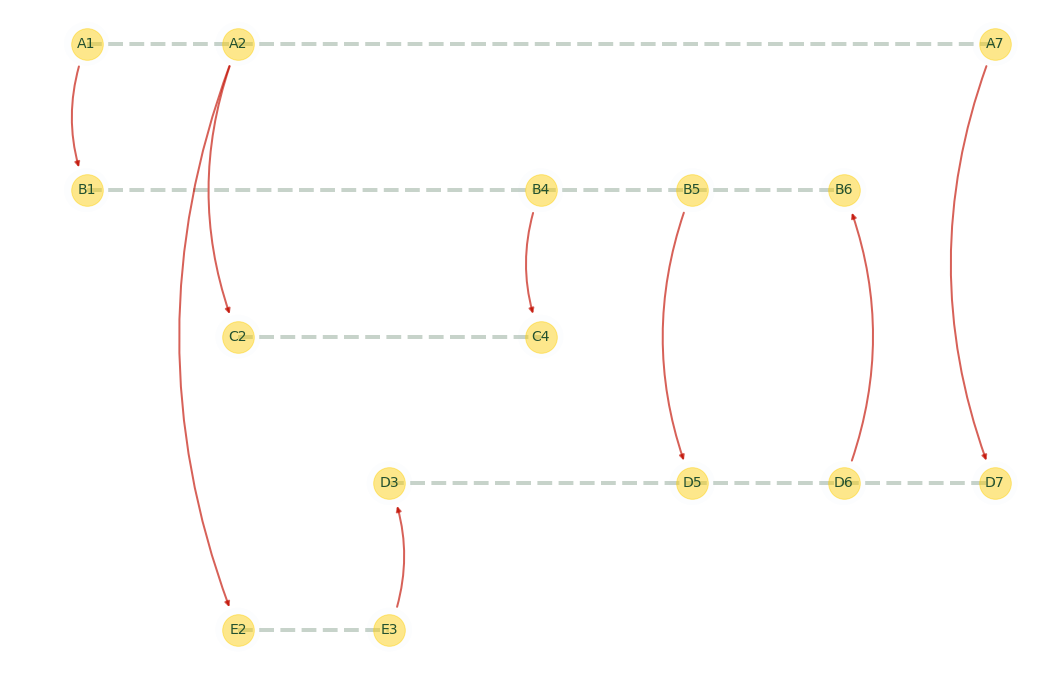

In [12]:
grafo_temporal.plot()

### Comprobar que los enlaces se crean cuando el dataframe tiene las columnas adecuadas:

In [13]:
set(data.columns.values)

{'recipient', 'sender', 'time'}

In [14]:
TemporalGraph(data.time)

In [15]:
data.rename(columns={'sender': 'emisor'}, inplace=True)
data.columns.values

array(['emisor', 'recipient', 'time'], dtype=object)

Probamos enviando un dataframe que no presenta las columnas esperadas:

In [16]:
g = TemporalGraph(data.time)
try:
    g.build_links_from_data(data=data)
except Exception as e:
    print(e)


            El dataframe especificado debe contener las columnas:
            sender, recipient, time


corregimos indicando que la columna que debe der interpretada como emisor es la de nombre 'emisor':

In [17]:
g.build_links_from_data(data=data, col_sender='emisor')

Enlace:  A B 2018-12-21 10:58:33.450464
Enlace:  A C 2018-12-21 10:58:35.450781
Enlace:  A E 2018-12-21 10:58:35.450781
Enlace:  E D 2018-12-21 10:58:39.451038
Enlace:  B C 2018-12-21 10:58:45.451378
Enlace:  B D 2018-12-21 10:58:53.451548
Enlace:  D B 2018-12-21 10:59:03.452187
Enlace:  A D 2018-12-21 10:59:15.452931


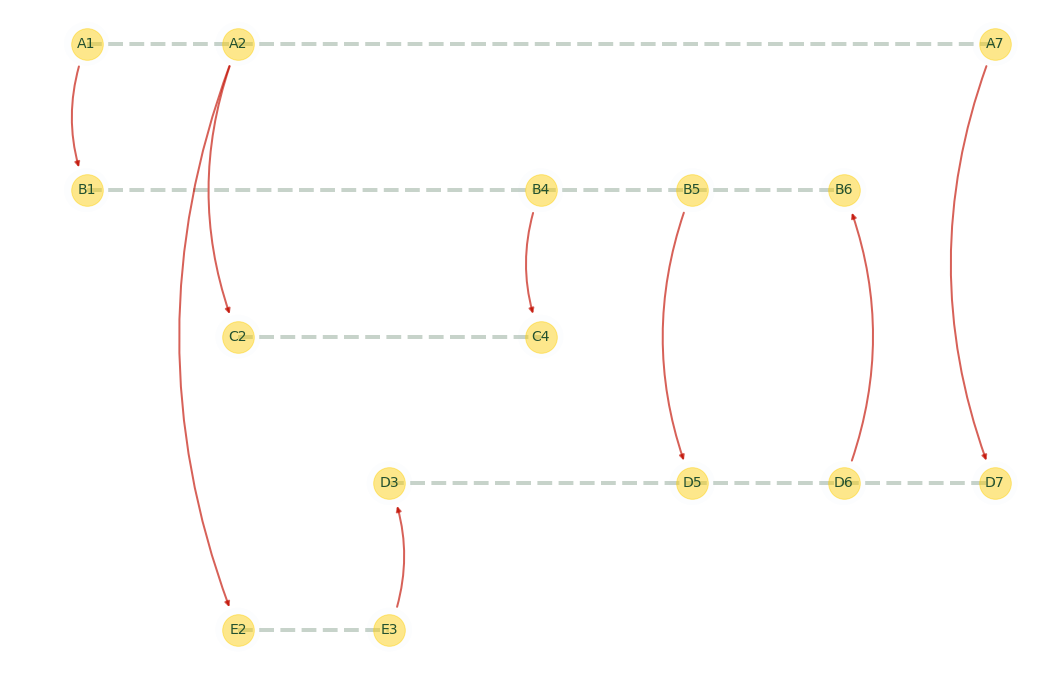

In [18]:
g.plot()

## Datos desde csv
Posiblemente una de las primeras fuentes de información que resulten útiles va a ser un archivo csv por lo cual incorporamos una forma de lidiar con esto de forma simple

In [19]:
mails_chain = pd.read_csv('data/mails.csv', encoding='latin1')
mails_chain.head()

,origen,destino,fecha
0,Sofía,María,12/03/2018
1,Sofía,Lucía,12/03/2018
2,Sofía,Martina,1/04/2018
3,Sofía,Catalina,1/04/2018
4,Catalina,Elena,1/04/2018


In [20]:
reemplazos, mailschain = limpiar_data(mails_chain, 'origen', 'destino', 'fecha')
mailschain.head()

,sender,recipient,time
0,a,c,2018-03-12
1,a,d,2018-03-12
2,a,e,2018-04-01
3,a,b,2018-04-01
4,b,f,2018-04-01


In [21]:
reemplazos

{'Sofía': 'a',
 'Catalina': 'b',
 'María': 'c',
 'Lucía': 'd',
 'Martina': 'e',
 'Elena': 'f',
 'Emilia': 'g',
 'Valentina': 'h',
 'Paula': 'i',
 'Pablo': 'j',
 'Matías': 'k',
 'Pedro': 'l',
 'Tomás': 'm',
 'Benjamín': 'n',
 'Santiago': 'o',
 'Mateo': 'p',
 'Thiago': 'q',
 'Zoe': 'r',
 'Juan': 's',
 'Nicolás': 't',
 'Santino': 'u',
 'Josefina': 'v'}

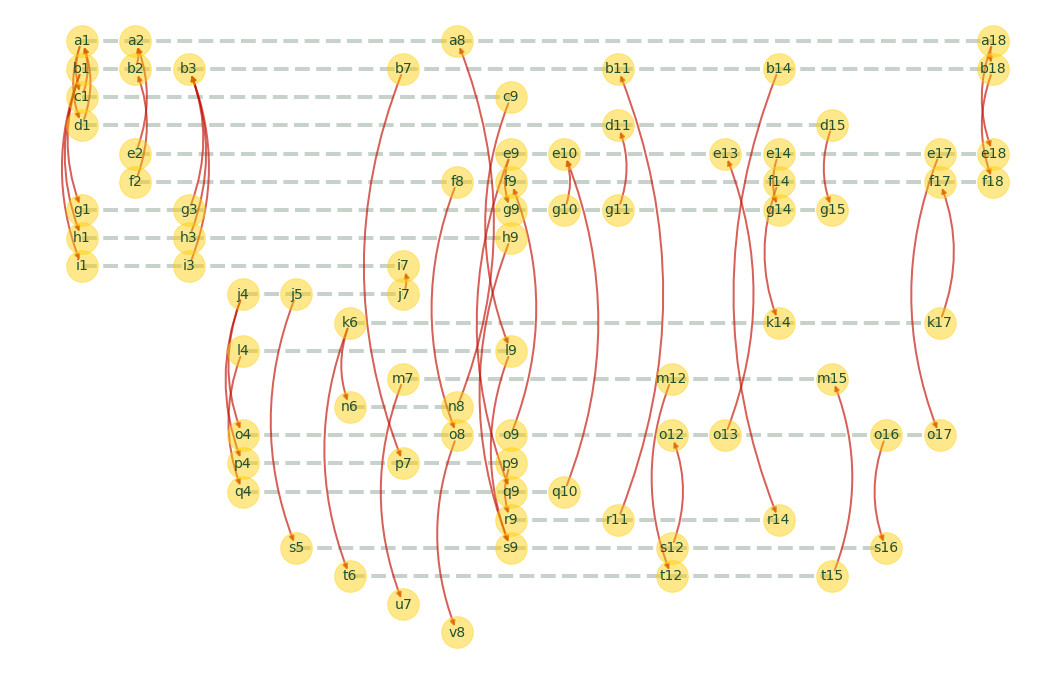

In [22]:
g = TemporalGraph(mailschain.time)
g.build_links_from_data(mailschain, verbose=False)
g.plot()

#### Testear paleta:

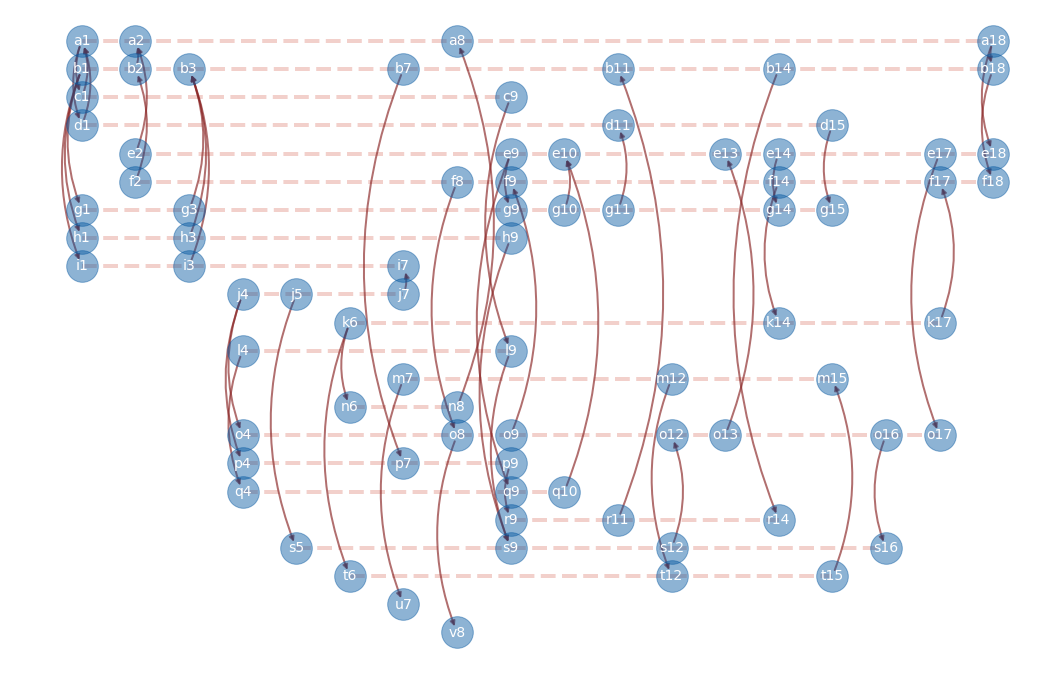

In [23]:
paleta = {
    'nodes_color': '#0457A0', #'#cc5522',
    'links_color': '#882222',
    'temp_links_color': '#cc4433',
    'label_color': 'white'
}
g.plot(paleta=paleta)

#### Testear generación de imágenes:

In [24]:
import os

In [25]:
os.listdir('output/')

[]

In [ ]:
g = TemporalGraph(mailschain.time)
g.build_links_from_data(mailschain, verbose=False, save_images=True)

In [ ]:
', '.join(os.listdir('output/'))

In [ ]:
from IPython.display import Image
Image(filename="output/grafo-temporal.gif")

## Trabajar con el grafo:

In [ ]:
g.get_graph()

continuar...